In [1]:
#!/usr/bin/env python3

from __future__ import print_function
from smodels.tools import runtime
# Define your model (list of BSM particles)
runtime.modelFile = 'smodels.share.models.mssm'
# runtime.modelFile = 'mssmQNumbers.slha'

from smodels.theory import decomposer
from smodels.tools.physicsUnits import fb, GeV, TeV
from smodels.theory.theoryPrediction import theoryPredictionsFor
from smodels.experiment.databaseObj import Database
from smodels.tools import coverage
from smodels.tools.theoryPredictionsCombiner import TheoryPredictionsCombiner
from smodels.tools.smodelsLogging import setLogLevel
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
import time
import os
setLogLevel("info")

In [2]:
# Set the path to the database
database = Database(os.path.expanduser('~/smodels-database'))

INFO in databaseObj.loadBinaryFile() in 503: loading binary db file /home/lessa/smodels-database/db31.pcl format version 214
INFO in databaseObj.loadBinaryFile() in 510: Loaded database from /home/lessa/smodels-database/db31.pcl in 2.3 secs.


In [3]:
model = Model(BSMparticles=BSMList, SMparticles=SMList)
slhafile = 'inputFiles/slha/lightEWinos.slha'
model.updateParticles(inputFile=slhafile)

# Set main options for decomposition
sigmacut = 0.005*fb
mingap = 5.*GeV

t0 = time.time()
# Decompose model
topDict = decomposer.decompose(model, sigmacut,
                               massCompress=True, invisibleCompress=True,
                               minmassgap=mingap)

# Access basic information from decomposition, using the topology list and topology objects:
print("\n Decomposition done in %1.2fm" %((time.time()-t0)/60.))
print("\n Decomposition Results: ")
print("\t  Total number of topologies: %i " % len(topDict))
nel = len(topDict.getSMSList())
print("\t  Total number of elements = %i " % nel)
# Print information about the m-th topology:
m = 2
if len(topDict) > m:
    cName = sorted(topDict.keys())[m]
    elementList = topDict[cName]
    print("\t\t %i topology  = " % cName)
    # Print information about the n-th element in the m-th topology:
    n = 0
    el = elementList[n]
    print("\t\t %i-th element  = " % (n), el, end="")
    print("\n\t\t\twith final states =", el.getFinalStates(), "\n\t\t\twith cross section =", el.weightList, "\n\t\t\tand masses = ", el.mass)


INFO in model.updateParticles() in 401: Loaded 62 BSM particles



 Decomposition done in 0.95m

 Decomposition Results: 
	  Total number of topologies: 57 
	  Total number of elements = 18544 
		 110110101000 topology  = 
		 0-th element  =  (PV > N1,C1-(1)), (C1-(1) > N1~,e-,nu)
			with final states = [N1, N1~, e-, nu] 
			with cross section = ['1.30E+01 [TeV]:7.03E-03 [pb] (-1000024, 1000022)', '8.00E+00 [TeV]:4.03E-03 [pb] (-1000024, 1000022)'] 
			and masses =  [None, 6.81E+01 [GeV], 1.34E+02 [GeV], 6.81E+01 [GeV], 5.00E-01 [MeV], 0.00E+00 [MeV]]


In [4]:
# Load the experimental results to be used.
# In this case, all results are employed.
listOfExpRes = database.getExpResults()

t0 = time.time()
# Print basic information about the results loaded.
# Count the number of loaded UL and EM experimental results:
nUL, nEM = 0, 0
for exp in listOfExpRes:
    expType = exp.datasets[0].dataInfo.dataType
    if expType == 'upperLimit':
        nUL += 1
    elif expType == 'efficiencyMap':
        nEM += 1
print("\n Loaded Database with %i UL results and %i EM results " % (nUL, nEM))

# Compute the theory predictions for each experimental result and print them:
print("\n Theory Predictions and Constraints:")
rmax = 0.
bestResult = None
allPredictions = []
for expResult in listOfExpRes:
    predictions = theoryPredictionsFor(expResult, topDict, combinedResults=False, marginalize=False)
    if not predictions:
        continue  # Skip if there are no constraints from this result
    print('\n %s ' % expResult.globalInfo.id)
    for theoryPrediction in predictions:
        dataset = theoryPrediction.dataset
        datasetID = theoryPrediction.dataId()
        mass = theoryPrediction.mass
        PIDs = theoryPrediction.PIDs
        txnames = sorted([str(txname) for txname in theoryPrediction.txnames])
        print("------------------------")
        print("Dataset = ", datasetID)  # Analysis name
        print("TxNames = ", txnames)
        print("Theory Prediction = ", theoryPrediction.xsection)  # Signal cross section
        print("Condition Violation = ", theoryPrediction.conditions)  # Condition violation values

        # Get the corresponding upper limit:
        print("UL for theory prediction = ", theoryPrediction.upperLimit)

        # Compute the r-value
        r = theoryPrediction.getRValue()
        print("r = %1.3E" % r)
        # Compute likelihoods for EM-type results:
        if dataset.getType() == 'efficiencyMap':
            theoryPrediction.computeStatistics()
            print('L_BSM, L_SM, L_max = %1.3E, %1.3E, %1.3E' % (theoryPrediction.likelihood(),
                  theoryPrediction.lsm(), theoryPrediction.lmax()))
        if r > rmax:
            rmax = r
            bestResult = expResult.globalInfo.id
        allPredictions.append(theoryPrediction)

# Print the most constraining experimental result
print("\nThe largest r-value (theory/upper limit ratio) is %1.3E" % rmax)
if rmax > 1.:
    print("(The input model is likely excluded by %s)" % bestResult)
else:
    print("(The input model is not excluded by the simplified model results)")

print("\n Theory Predictions done in %1.2fm" %((time.time()-t0)/60.))


 Loaded Database with 125 UL results and 60 EM results 

 Theory Predictions and Constraints:

 ATLAS-SUSY-2015-06 
------------------------
Dataset =  SR5j
TxNames =  ['T1', 'T2']
Theory Prediction =  5.43E-06 [pb]
Condition Violation =  None
UL for theory prediction =  1.79E+00 [fb]
r = 3.031E-03
L_BSM, L_SM, L_max = 7.167E-03, 7.215E-03, 7.215E-03

 ATLAS-SUSY-2016-07 
------------------------
Dataset =  None
TxNames =  ['T2']
Theory Prediction =  2.54E-05 [pb]
Condition Violation =  None
UL for theory prediction =  3.83E+02 [fb]
r = 6.621E-05

 ATLAS-SUSY-2016-07 
------------------------
Dataset =  5j_Meff_1600
TxNames =  ['T1', 'T2', 'T5WWoff', 'TGQ']
Theory Prediction =  2.76E-04 [pb]
Condition Violation =  None
UL for theory prediction =  1.27E+00 [fb]
r = 2.173E-01
L_BSM, L_SM, L_max = 9.650E-04, 9.077E-04, 9.778E-04

 ATLAS-SUSY-2016-24 
------------------------
Dataset =  None
TxNames =  ['TSlepSlep']
Theory Prediction =  2.24E-05 [pb]
Condition Violation =  [0.0]
UL for th


 CMS-SUS-16-043 
------------------------
Dataset =  None
TxNames =  ['TChiWH']
Theory Prediction =  6.10E-04 [pb]
Condition Violation =  None
UL for theory prediction =  4.71E+02 [fb]
r = 1.295E-03

 CMS-SUS-16-045 
------------------------
Dataset =  None
TxNames =  ['TChiWH']
Theory Prediction =  6.10E-04 [pb]
Condition Violation =  None
UL for theory prediction =  1.36E+03 [fb]
r = 4.482E-04

 CMS-SUS-16-048 
------------------------
Dataset =  stop_lowMET_PT_12to20
TxNames =  ['TChiWZoff']
Theory Prediction =  2.50E-05 [pb]
Condition Violation =  None
UL for theory prediction =  9.96E-01 [fb]
r = 2.514E-02
L_BSM, L_SM, L_max = 1.298E-03, 1.135E-03, 3.272E-03

 CMS-SUS-17-004 
------------------------
Dataset =  None
TxNames =  ['TChiWZ']
Theory Prediction =  2.79E-04 [pb]
Condition Violation =  None
UL for theory prediction =  1.18E+02 [fb]
r = 2.362E-03
------------------------
Dataset =  None
TxNames =  ['TChiWH']
Theory Prediction =  6.10E-04 [pb]
Condition Violation =  None
U


 ATLAS-SUSY-2013-09 
------------------------
Dataset =  None
TxNames =  ['T1tttt']
Theory Prediction =  6.70E-04 [pb]
Condition Violation =  None
UL for theory prediction =  2.90E+01 [fb]
r = 2.314E-02

 ATLAS-SUSY-2013-09 
------------------------
Dataset =  SR3B
TxNames =  ['T1tttt']
Theory Prediction =  7.66E-06 [pb]
Condition Violation =  None
UL for theory prediction =  1.76E-01 [fb]
r = 4.353E-02
L_BSM, L_SM, L_max = 1.224E-01, 1.321E-01, 1.321E-01

 ATLAS-SUSY-2013-11 
------------------------
Dataset =  None
TxNames =  ['TSlepSlep']
Theory Prediction =  1.04E-05 [pb]
Condition Violation =  [0.0]
UL for theory prediction =  2.72E+00 [fb]
r = 3.822E-03
------------------------
Dataset =  None
TxNames =  ['TChiWZ']
Theory Prediction =  1.64E-04 [pb]
Condition Violation =  None
UL for theory prediction =  1.39E+02 [fb]
r = 1.181E-03

 ATLAS-SUSY-2013-11 
------------------------
Dataset =  mT2-150-SF
TxNames =  ['TChiWW', 'TSlepSlep']
Theory Prediction =  7.26E-07 [pb]
Condition 


 CMS-SUS-14-010 
------------------------
Dataset =  None
TxNames =  ['T1tttt']
Theory Prediction =  6.70E-04 [pb]
Condition Violation =  None
UL for theory prediction =  1.75E+01 [fb]
r = 3.835E-02

The largest r-value (theory/upper limit ratio) is 4.783E+00
(The input model is likely excluded by ATLAS-SUSY-2019-09)

 Theory Predictions done in 3.06m


In [5]:
t0 = time.time()
# Select a few results results for combination:
combineAnas = ['ATLAS-SUSY-2013-11', 'CMS-SUS-13-013']
selectedTheoryPreds = []
for tp in allPredictions:
    expID = tp.analysisId()
    if expID not in combineAnas:
        continue
    if tp.likelihood() is None:
        continue
    selectedTheoryPreds.append(tp)
# Make sure each analysis appears only once:
expIDs = [tp.analysisId() for tp in selectedTheoryPreds]
if len(expIDs) != len(set(expIDs)):
    print("\nDuplicated results when trying to combine analyses. Combination will be skipped.")
# Only compute combination if at least two results were selected
elif len(selectedTheoryPreds) > 1:
    combiner = TheoryPredictionsCombiner(selectedTheoryPreds)
    combiner.computeStatistics()
    llhd = combiner.likelihood()
    lmax = combiner.lmax()
    lsm = combiner.lsm()
    print("\n\nCombined analyses:", combiner.analysisId())
    print("Combined r value: %1.3E" % combiner.getRValue())
    print("Combined r value (expected): %1.3E" % combiner.getRValue(expected=True))
    print("Likelihoods: L, L_max, L_SM = %10.3E, %10.3E, %10.3E\n" % (llhd, lmax, lsm))

print("\n Combination of analyses done in %1.2fm" %((time.time()-t0)/60.))



Combined analyses: ATLAS-SUSY-2013-11,CMS-SUS-13-013
Combined r value: 2.183E-02
Combined r value (expected): 2.183E-02
Likelihoods: L, L_max, L_SM =  1.385E-02,  1.401E-02,  1.394E-02


 Combination of analyses done in 0.00m


In [6]:
t0 = time.time()
# Find out missing topologies for sqrts=13*TeV:
uncovered = coverage.Uncovered(topDict, sqrts=13.*TeV)
print("\n Coverage done in %1.2fm" %((time.time()-t0)/60.))


 Coverage done in 1.05m


In [7]:
# First sort coverage groups by label
groups = sorted(uncovered.groups[:], key=lambda g: g.label)
# Print uncovered cross-sections:
for group in groups:
    print("\nTotal cross-section for %s (fb): %10.3E\n" % (group.description, group.getTotalXSec()))


Total cross-section for missing topologies (fb):  1.120E+04


Total cross-section for missing topologies with displaced decays (fb):  0.000E+00


Total cross-section for missing topologies with prompt decays (fb):  1.399E+04


Total cross-section for topologies outside the grid (fb):  3.746E+03



In [8]:
missingTopos = uncovered.getGroup('missing (prompt)')
# Print some of the missing topologies:
if missingTopos.finalStateSMS:
    print('Missing topologies (up to 3):')
    for genEl in missingTopos.finalStateSMS[:3]:
        print('Element:', genEl)
        print('\tcross-section (fb):', genEl.missingX)
else:
    print("No missing topologies found\n")

Missing topologies (up to 3):
Element: (PV > MET,MET,jet,jet,l,nu)
	cross-section (fb): 1203.8783553949456
Element: (PV > MET,MET,jet,jet,ta,nu)
	cross-section (fb): 600.4536496545026
Element: (PV > MET,MET,jet,jet,jet,jet,t,b,b,b)
	cross-section (fb): 515.0638147985978


In [9]:
missingDisplaced = uncovered.getGroup('missing (displaced)')
# Print elements with displaced decays:
if missingDisplaced.finalStateSMS:
    print('\nElements with displaced vertices (up to 2):')
    for genEl in missingDisplaced.finalStateSMS[:2]:
        print('Element:', genEl)
        print('\tcross-section (fb):', genEl.missingX)
else:
    print("\nNo displaced decays")



No displaced decays


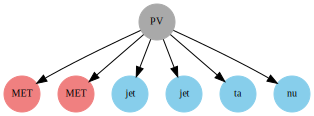

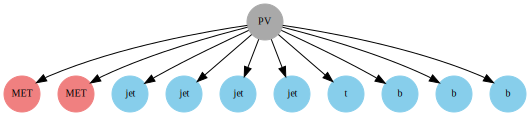

In [10]:
smsA = missingTopos.finalStateSMS[1]
smsB = missingTopos.finalStateSMS[2]
smsA.draw()
smsB.draw()

In [11]:
smsA == smsB

False

In [12]:
from bisect import bisect, bisect_left

smsList = missingTopos.finalStateSMS[:2] + missingTopos.finalStateSMS[3:5]
for sms in smsList:
    print(sms)
index = bisect(smsList, smsB)
print(index)

(PV > MET,MET,jet,jet,l,nu)
(PV > MET,MET,jet,jet,ta,nu)
(PV > MET,MET,jet,jet,jet,jet,jet,t,b,W)
(PV > MET,MET,jet,jet)
4


In [13]:
x = [1,2,2,3,4,5]
bisect(x,2),bisect_left(x,2)

(3, 1)

In [14]:
bisect(x,3),bisect_left(x,3)

(4, 3)